### Stuart-Landau Model

In [1]:
import sys
import os
sys.path.insert(1, os.path.join("/", *os.getcwd().split("/")[:-1]))

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from tqdm import tqdm

from src.models import simulate

#### Simulation parameters

In [3]:
Nareas = 1
ntrials = 1
fsamp = 1 / 1e-5

time = np.arange(-4, 2, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 10

C = np.array([0]).T


a = -7
I0 = 47
f = 1

In [4]:
time_start = 0
time_end = np.inf
Iext = (time > time_start) & (time < time_end)

#### Amplitude only

In [5]:
out = simulate(
    C,
    0,
    f,
    a,
    fsamp,
    0 * beta,
    Npoints,
    I0 * Iext[None,],
    6187,
    "cpu",
    decim,
    "amp",
)

In [6]:
def func(r):
    return a * r - r**3 + I0


root = scipy.optimize.newton(func, 0, fprime=lambda r: a - 3 * r**2)

(-1.0, 2.0)

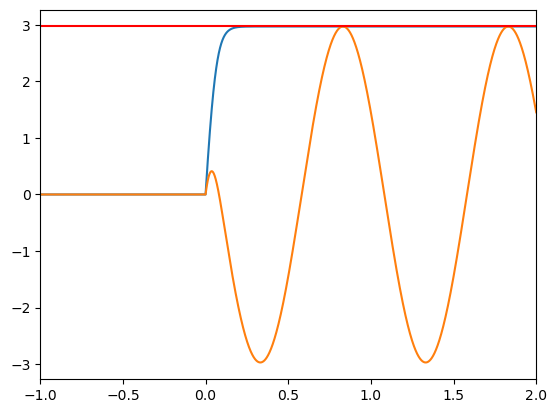

In [7]:
plt.plot(time[::decim], np.abs(out))
plt.plot(time[::decim], np.real(out))

plt.hlines(root, -1, 2, "r")

plt.xlim(-1, 2)

In [8]:
roots = []

for A in np.arange(1, 10000, 1):

    def func(r):
        return -5 * r - r**3 + A

    roots += [scipy.optimize.newton(func, 0, fprime=lambda r: -5 - 3 * r**2)]

/tmp/ipykernel_1414255/2848565260.py:2: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x + c) + d


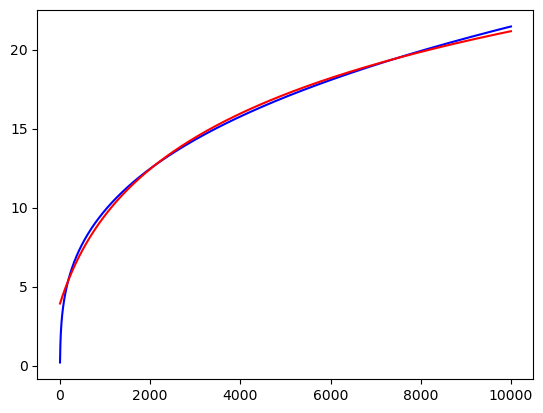

In [9]:
def func(x, a, b, c, d):
    return a * np.log(b * x + c) + d


xdata = np.arange(1, 10000, 1)
ydata = np.stack(roots)
plt.plot(xdata, ydata, "b-", label="data")

popt, pcov = scipy.optimize.curve_fit(func, xdata, ydata)
popt
plt.plot(xdata, func(xdata, *popt), "r-")

#### Real-valued input

In [10]:
out = simulate(
    C,
    0,
    f,
    a,
    fsamp,
    0 * beta,
    Npoints,
    I0 * Iext[None,],
    6187,
    "cpu",
    decim,
    "both",
)

In [11]:
import sympy as sp

# Define variable
r = sp.symbols('r', real=True, positive=True)

# Parameters
omega = 2 * sp.pi * f
# Fixed point equation
fixed_point_eq = a*r - r**3 + sp.sqrt(I0**2 - omega**2 * r**2)

# Try multiple initial guesses below 0.159 (valid range)
initial_guesses = np.arange(0, 1, 0.001)
 
# Try solving
for guess in initial_guesses:
    try:
        r_star = sp.nsolve(fixed_point_eq, r, guess)
        theta_star = sp.asin(omega * r_star / I0)
        print(f"Found solution:")
        print(f"r* = {r_star.evalf()}")
        print(f"theta* = {theta_star.evalf()}")
        break
    except Exception as e:
        continue

Found solution:
r* = 2.86045085545222
theta* = 0.392390998773792


In [12]:
r_float = float(r_star.evalf().as_real_imag()[0])  # First element is the real part

(-1.0, 2.0)

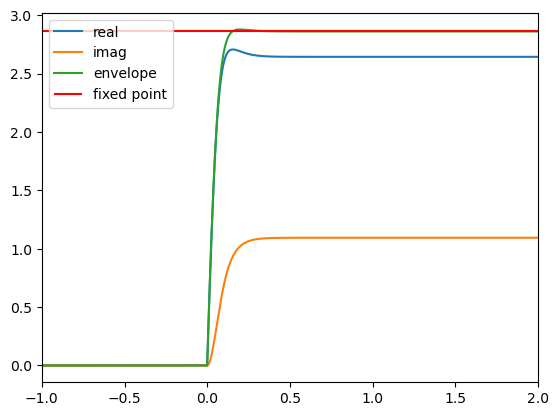

In [13]:
plt.plot(time[::decim], np.real(out))
plt.plot(time[::decim], np.imag(out))
plt.plot(time[::decim], np.abs(out))
plt.hlines(r_float , -1, 2, "r")

plt.legend(["real", "imag", "envelope", "fixed point"])

plt.xlim(-1, 2)